# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 2. Read and Preprocessing datadata

In [2]:
df = pd.read_csv("C:/ML/Labwork4/dataset/RandomForest/adult.csv")

# CLeaning the data
df = df.dropna(how = 'all')
df.columns = df.columns.str.strip()
for col in df.select_dtypes('object'):
    df[col] = df[col].str.strip()

# Splitting the data to train and test
target_col = 'income' if 'income' in df.columns else df.columns[-1]
x = df.drop(columns=target_col)
y = df[target_col]

y = y.str.replace('.', '', regex=False).str.strip()

class_counts = y.value_counts()
rare_classes = class_counts[class_counts < 2].index
if len(rare_classes):
    print(f"Dropping {len(rare_classes)} rare class(es): {list(rare_classes)}")
    mask = ~y.isin(rare_classes)
    X, y = x[mask], y[mask]

x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Separate number column and category column
numerical_cols = x.select_dtypes(include = ['int64', 'float64']).columns
categorical_cols = x.select_dtypes(exclude = ['int64', 'float64']).columns

# Preprocessing the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_cols)
    ])

# 3. Bagging: create 100 bootstrap training sets and train the RF model

In [3]:
K = 100
errors = []

for k in range(K):
    idx = np.random.choice(len(x_train_full), len(x_train_full), replace=True)
    x_boot, y_boot = x_train_full.iloc[idx], y_train_full.iloc[idx]

    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', RandomForestClassifier(n_estimators=100, random_state=k, n_jobs=-1))
    ])
    
    pipe.fit(x_boot, y_boot)
    y_pred = pipe.predict(x_test)
    error = 1 - accuracy_score(y_test, y_pred)
    errors.append(error)

# 4. Training Decision Tree

In [4]:
dt = DecisionTreeClassifier(random_state=42)
dt_pipe = Pipeline([('prep', preprocessor), ('model', dt)])
dt_pipe.fit(x_train_full, y_train_full)
y_pred_dt = dt_pipe.predict(x_test)
dt_error = 1 - accuracy_score(y_test, y_pred_dt)

# 5. Compare result

In [5]:
errors = np.array(errors)
print("\n=== Compare Random Forest (RF) và Decision Tree (DT) ===")
print(f"Decision Tree Error: {dt_error:.4f}")
print(f"Random Forest Average Error (100 models): {errors.mean():.4f}")
print(f"Random Forest Min Error: {errors.min():.4f}")
print(f"Random Forest Max Error: {errors.max():.4f}")


=== Compare Random Forest (RF) và Decision Tree (DT) ===
Decision Tree Error: 0.1855
Random Forest Average Error (100 models): 0.1461
Random Forest Min Error: 0.1405
Random Forest Max Error: 0.1531


# 6. Visual Chart

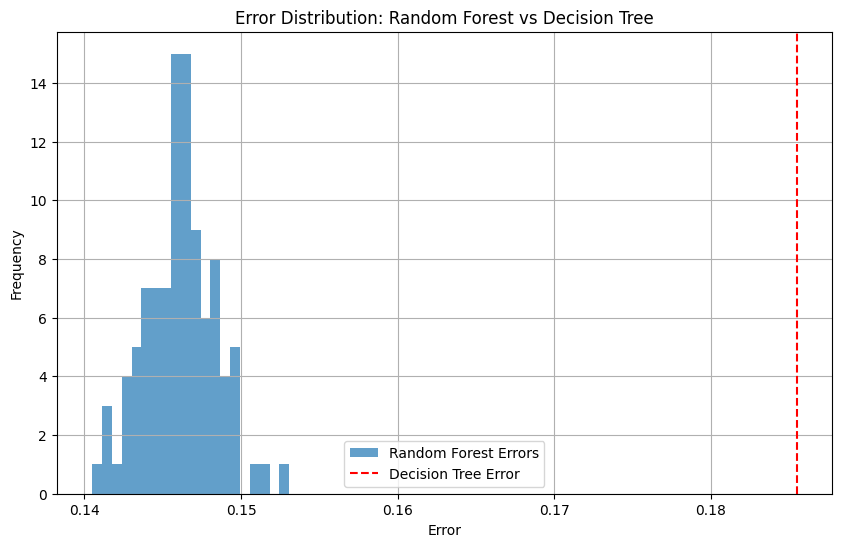

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, alpha=0.7, label='Random Forest Errors')
plt.axvline(dt_error, color='red', linestyle='--', label='Decision Tree Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution: Random Forest vs Decision Tree')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("C:/ML/Labwork4/visualizations/RandomForest/RandomForest_vs_DecisionTree_adult.png")